# Influence Function

$$
\renewcommand{\paren}[1]{\left(#1\right)}
\renewcommand{\brac}[1]{\left[#1\right]}
\renewcommand{\sumi}[]{\sum_{i=1}^N}
\renewcommand{\htheta}[]{\hat{\theta}}
\renewcommand{\hthetami}[]{\htheta_{- i}}
\renewcommand{\hthetamie}[]{\hthetami(\epsilon)}
\renewcommand{\nablat}[]{\nabla_{\theta}}
\renewcommand{\nablatt}[]{\nabla_{\theta}^2}
\renewcommand{\evale}[1]{\left.#1\right|_{\epsilon=0}}
$$


In [1]:
from __future__ import annotations
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

In [3]:
def generate_simulation_data(
    n_incetances: int,
) -> tuple[np.ndarray, np.ndarray]:
    """シミュレーションデータを生成する"""

    x = np.random.normal(0, 1, n_incetances)
    u = np.random.normal(0, 0.1, n_incetances)

    y = x + u

    # 外れ値で上書きする
    x[0] = 2
    y[0] = -2

    return (x, y)


x, y = generate_simulation_data(n_incetances=20)

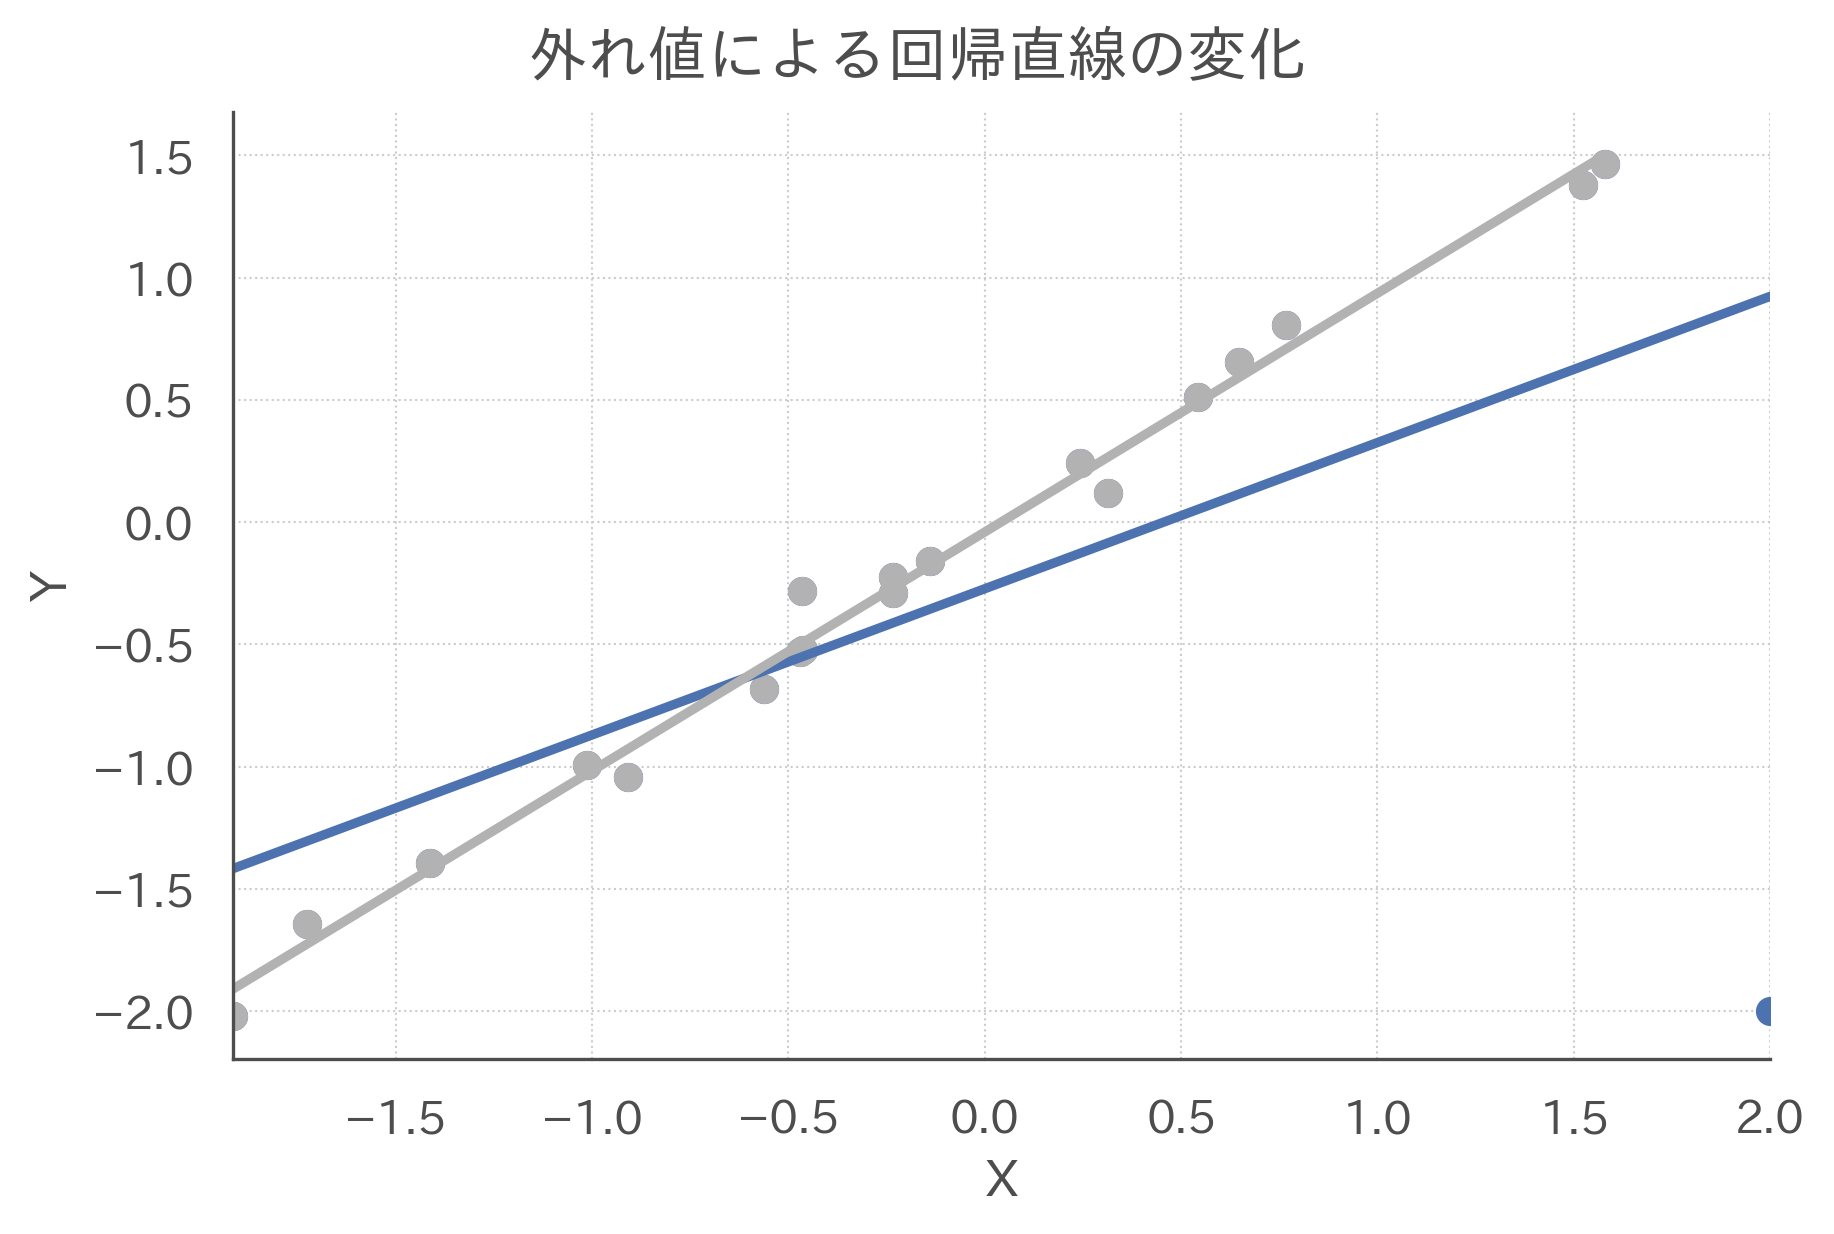

In [4]:
def draw_regression_line(x: np.ndarray, y: np.ndarray) -> None:
    """外れ値を含んだ場合と含まない場合の回帰直線を可視化する"""

    fig, ax = plt.subplots()
    sns.regplot(x, y, scatter_kws=dict(alpha=1), ci=None, ax=ax)
    sns.regplot(x[1:], y[1:], scatter_kws=dict(alpha=1), color=".7", ci=None, ax=ax)
    ax.set(xlabel="X", ylabel="Y")
    fig.suptitle("外れ値による回帰直線の変化")
    fig.savefig(f"output/outlier.png")
    fig.show()


draw_regression_line(x, y)

In [5]:
def calc_leave_one_out_error_diff(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """LOOでの予測誤差を計算する"""

    n_incetances = x.shape[0]
    X = x.reshape(-1, 1)
    y_pred = LinearRegression().fit(X, y).predict(X)

    error_diff = np.zeros((n_incetances, n_incetances))
    for i in range(n_incetances):
        X_loo = np.delete(X, i, 0)
        y_loo = np.delete(y, i, 0)

        y_pred_loo = LinearRegression().fit(X_loo, y_loo).predict(X)
        error_diff[:, i] = (y - y_pred_loo) ** 2 - (y - y_pred) ** 2

    return error_diff


looed = calc_leave_one_out_error_diff(x, y)
avg_diff = looed.mean(0) # 平均的な誤差を計算

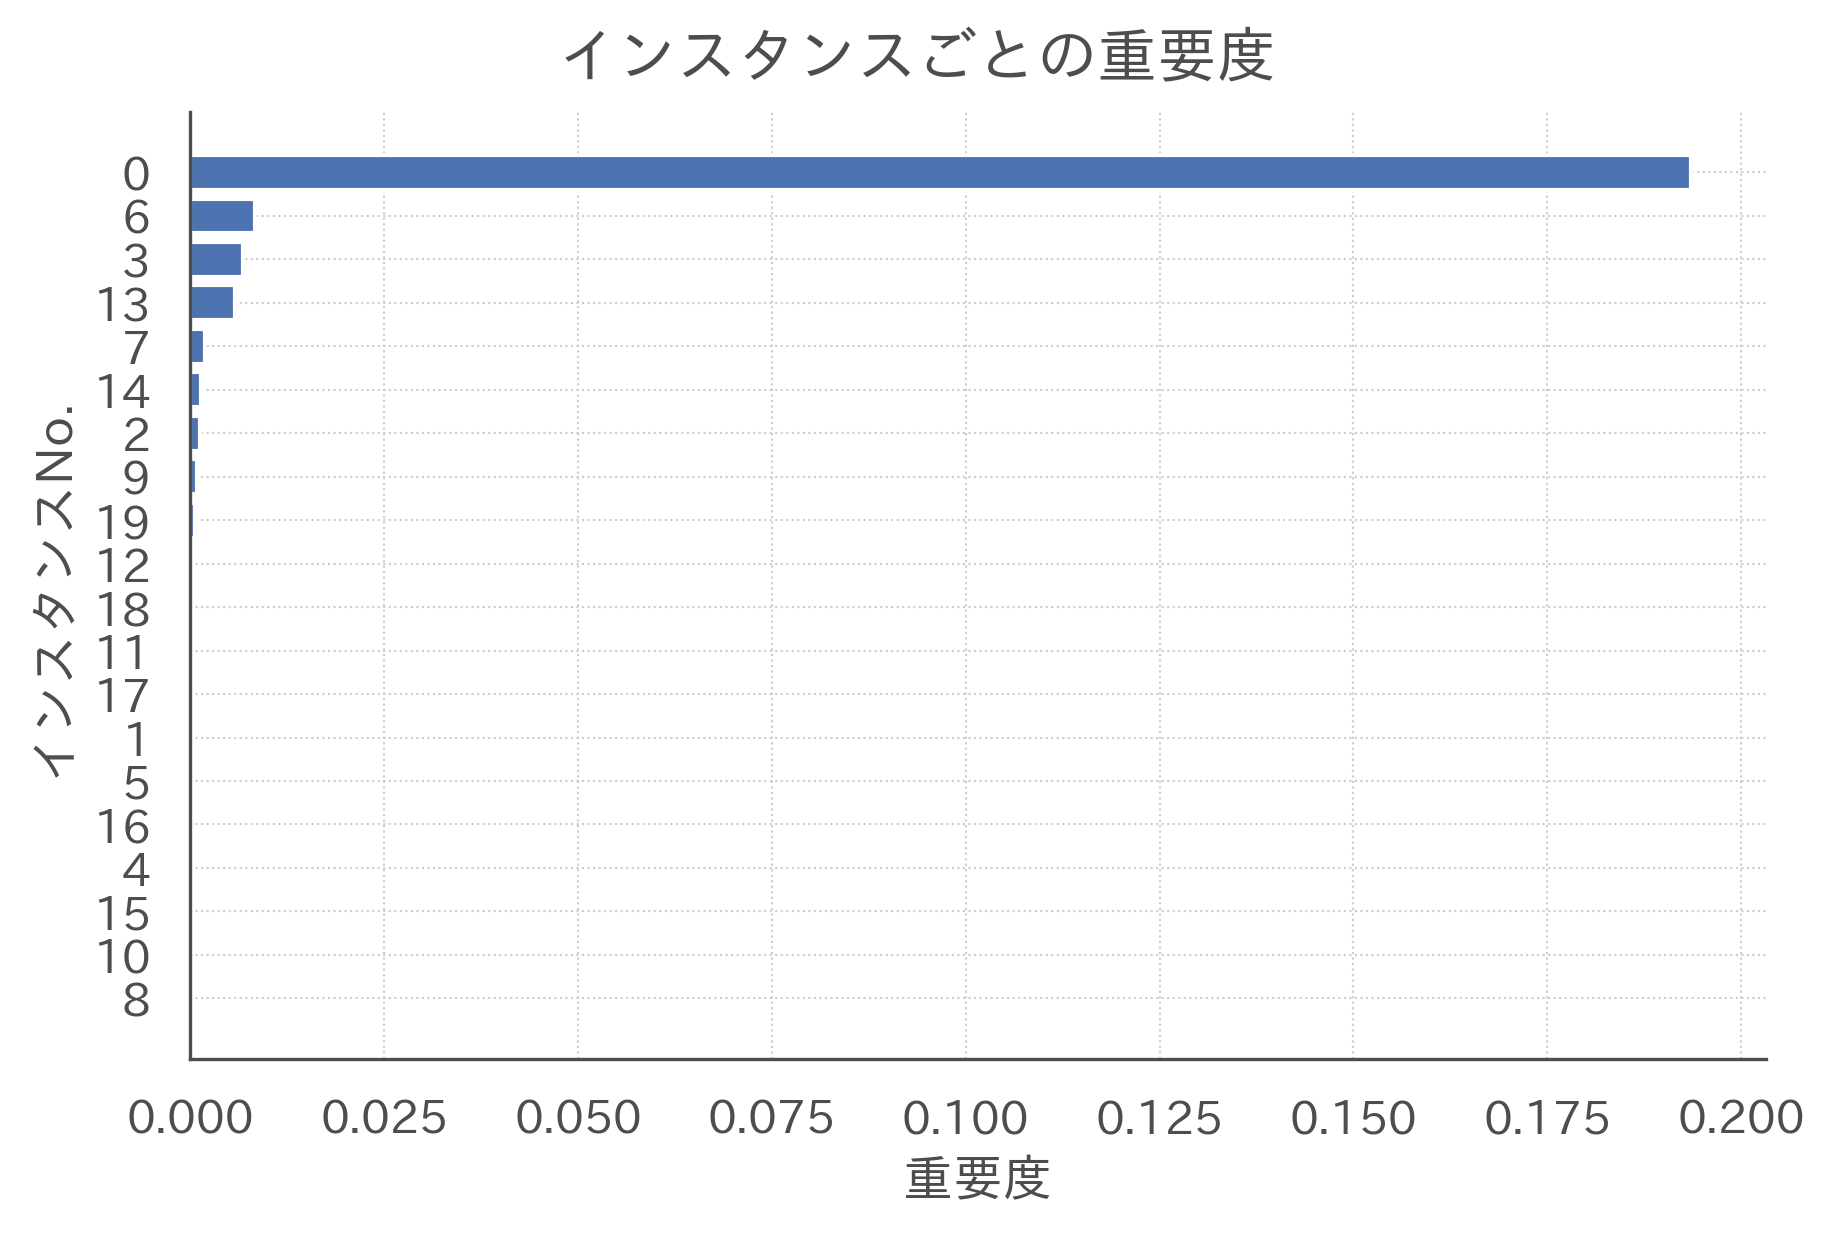

In [6]:
def draw_importance(imp: np.ndarray) -> None:
    """インスタンスごとの重要度を可視化する"""

    df = (
        pd.DataFrame({"importance": imp})
        .reset_index()
        .rename({"index": "instance"}, axis=1)
        .sort_values("importance")
        .reset_index(drop=True)
        .assign(instance=lambda df: df.instance.astype(str))
    )
    
    fig, ax = plt.subplots()
    ax.barh(df["instance"], df["importance"])
    ax.set(xlabel="重要度", ylabel="インスタンスNo.")
    fig.suptitle("インスタンスごとの重要度")
    fig.savefig(f"output/imp.png")
    fig.show()


draw_importance(avg_diff)

Permutation Feature Importance（PFI）、Partial Dependence（PD）、Accumulated Local Effects（ALE）などの機械学習の解釈手法は、特徴量とモデルの予測値の関係を通じて機械学習モデルを解釈する手法でした。
たとえば、PFIでは「どの特徴量がモデルにとって重要なのか」という視点でブラックボックスモデルに解釈性を与えることが出来ます。
特徴量重要度の用途の一つはデバッグです。
ドメイン知識から考えると不自然な重要度をもつ特徴量が存在すれば、データやモデルに不備があるのかもしれません。
また、重要度が極端に高い特徴量は、何か情報がリークしている可能性があります。


このように、「どの**特徴量**がモデルにとって重要なのか」を知ることはモデルの振る舞いを解釈する上で重要です。
ここでは特徴量に注目していますが、視点を変えてインスタンスに注目することもできます。
つまり、「どの**インスタンス**がモデルにとって重要なのか」という解釈性も、機械学習モデルの振る舞いを理解する上で役に立ちそうです。
同様にモデルのデバッグを考えると、極端に重要度の高いインスタンスが存在すれば、そのインスタンスを外れ値として除外する、そもそもデータとしておかしいのではないか確認するなどの対応が取れます。


「どのインスタンスがモデルにとって重要なのか」を知ることには意味がありそうですが、これを知るためにはそもそも何をもって**重要**とみなすかをきちんと定義する必要があります。
ストレートに考えると「そのインスタンスの有無でモデルの予測がどのくらい大きく変わるか」をもって重要度を定義できそうです。

具体例として、下図を見てください。
右下の外れ値を学習データに入れた場合と入れなかった場合での線形回帰の予測線を可視化しています。
外れ値を入れると回帰直線の傾きが緩やかになることが見て取れます。

このように、そのインスタンスを学習データに含めることでどれだけ予測値が変化するのか、そしてその結果としてどれだけ予測精度が変化するのかを計算し、それをインスタンスの重要度とすることができそうです。
この重要度計算アルゴリズムは、インスタンスをひとつずつ取り除いて（Leave One Out, LOO）繰り返し学習と予測を行うだけなので、簡単に実装することが出来ます。

LOOによる予測誤差の変化は直感的でわかりやすいですが、再学習が必要なので計算に時間がかかることが欠点です。
今回のシミュレーションではインスタンスの数が20でモデルは線形回帰だったのですぐに計算は終わりましたが、実務の際にはより大量のデータをより複雑なモデルで分析します。
ですので、より複雑な問題に取り組む際には、再学習を必要としないアルゴリズムが必要になります。

実は、これを解決するアルゴリズムがKoh and Liang(2017)で提案されています。
このアルゴリズムはInfluence Functionを利用しており、それを記述するためにいくつかの記号を導入します。

- 特徴量とアウトカムの組を$z = (x, y)$とします
- モデルはパラメトリックなモデルを採用し、そのパラメータを$\theta$で表します
    - パラメータは$K$個あるとします。つまり、$\theta = (\theta_1, \dots, \theta_K)$とします
- 損失関数を$L(z, \theta) = L(y, f(x, \theta))$で定義します
    - モデルが線形回帰で損失関数が二乗誤差なら$L(z, \theta)=\paren{y - x^\top\theta}^2$です
- データに対する予測誤差の総和を$R(\theta) = \sumi L(z_i, \theta)$で表します
    - モデルが線形回帰で損失関数が二乗誤差なら$R(\theta)=\sumi\paren{y_i - x_i^\top\theta}^2$です

さて、モデルは予測誤差が最も小さくなるようにパラメータ$\theta$を選びます。
つまり、全インスタンスを学習した場合のパラメータ$\htheta$は
$$
\htheta = \arg\min_{\theta \in \Theta}\sumi L(z_i, \theta)
$$
であり、インスタンス$i$を取り除いたデータで学習した場合のパラメータ$\hthetami$は
$$
\hthetami = \arg\min_{\theta \in \Theta} \sum_{j \neq i} L(z_j, \theta)
$$
となります。

この記法を用いると、インスタンス$i$を使わずにモデルの学習を行った場合に、インスタンス$j$の予測誤差に与える影響は以下のように表現できます。
$$
L\paren{z_j, \hthetami} - L\paren{z_i, \htheta}
$$
ここで、
- $L\paren{z_j, \hthetami}$はインスタンス$i$を取り除いたデータで学習を行い、インスタンス$j$を予測した場合の誤差
- $ L\paren{z_i, \htheta}$は全データで学習を行い、インスタンス$j$を予測した場合の誤差

を表します。

前述のように、このようなLOOによるインスタンスの重要度の計算はモデルの再学習が必要なので時間がかかるという問題がありました。
これを克服するためには、モデルの再学習を行わなずに再学習を行った場合の結果を近似できるような手法を考える必要があります。

手始めに、以下のような最小化問題を考えてみます。
$$
\hthetamie = \arg\min_{\theta \in \Theta} \sumi L(z_j, \theta) - \epsilon L(z_i, \theta)
$$

ここで、$\epsilon L(z_i, \theta)$という項が追加されています。
この項に注目すると、以下の性質があることが見て取れます。
- $\epsilon = 0$のとき、全インスタンスを用いた最小化問題と一致する
    - つまり、$\hthetami(0) = \htheta$
- $\epsilon = 1$のとき、インスタンス$i$を取り除いた最小化問題と一致する
    - つまり、$\hthetami(1) = \hthetami$

$0 < \epsilon < 1$の場合は、これらの中間の状態で、インスタンス$i$を完全に取り除いた（重みをゼロにした）状態や、全データを用いた状態ではなく、インスタンス$i$の重みをちょっとだけ（$\epsilon$だけ）軽くした状態を考えています。
よって、$\epsilon$はインスタンス$i$の重みをコントロールするパラメータと解釈できます。


この最小化問題の解として与えられる$\hthetamie$を用いた場合、任意の$z = (x, y)$に対する予測誤差は$L(z, \hthetami(\epsilon))$です。
ここで、$\epsilon$を0から少しだけ変化させたときに、どのくらい誤差が変化するかを考えます。
なんでこんなことを考えるのかを平たく言うと以下になります。
- ほんとは$\epsilon = 0$の場合と$\epsilon = 1$の場合の予測誤差の変化を見たい
- →それは再学習が必要になってしんどい
- →それなら$\epsilon$が0からちょっとだけ変化したときの予測誤差の変化を使って、$\epsilon$を1単位変化させた場合の（0から1まで持っていた場合の）予測誤差の変化を近似しよう

さて、上記の操作は予測誤差$L(z, \hthetami(\epsilon))$を$\epsilon$で微分して$\epsilon=0$で評価すれば実行できます。
$$
\begin{align}
    \evale{\frac{d L(z, \hthetami(\epsilon))}{d \epsilon}}
    &= \evale{\nablat L(z, \hthetamie)^\top \frac{d \hthetamie}{d\epsilon}}\\
    &= \evale{\nablat L(z, \htheta)^\top \frac{d \hthetamie}{d\epsilon}}
\end{align}
$$
ここで、
$\evale{\hthetami(\epsilon)} = \hthetami(0) = \htheta$を利用しています。
$\nablat L(z, \htheta)$は全データで学習したモデルを用いた予測誤差で求まります。
ですので、残りの$\evale{\frac{d \hthetamie}{d\epsilon}}$をどうやって求めるかがわかれば、これを計算できます。

それでは$\hthetamie$の性質を調べます。そもそも$\hthetamie$がどうやって計算されていたかを思い出すと、
$$
\hthetamie = \arg\min_{\theta \in \Theta} \sumi R(\theta) - \epsilon L(z_i, \theta)
$$
でした。
この後の操作を可能にするために、$R(\theta)$は$\theta$に関してstrongly convexで2階微分可能であることを仮定します（例えば、モデルが線形回帰で損失が二乗誤差だとこれを満たしますが、Neural Netなどより複雑なモデルだとstrongly convexの条件を満たさない可能性はあります）。

$\hthetamie$は目的関数を最小化する値なので、1階条件
$$
    \nablat R(\hthetamie) - \nablat L(z_i, \hthetamie)\epsilon = 0
$$
を満たします。

ここで、左辺を$\htheta$の周りで1階のテイラー展開すると以下を得ます。
$$
 \paren{\nablat R(\htheta) - \nablat L(z_i, \htheta)\epsilon} + \paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}\paren{\hthetamie - \htheta} + \mathrm{residual}
$$
ところで、$\htheta$は$R(\theta)$を最小化する値なので、$\nablat R(\htheta) = 0$です。ついでに剰余項を無視して近似すると
$$
0 \approx - \nablat L(z_i, \htheta)\epsilon + \paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}\paren{\hthetamie - \htheta}
$$
なので、整理すると
$$
\paren{\hthetamie - \htheta} \approx \paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}^{-1}\nablat L(z_i, \htheta)\epsilon
$$
となります。

<!-- $\epsilon = 0$のときは$\hthetami(0) = \htheta$だっとことを思い出すと、 -->
$\epsilon$を$0$からちょっとだけ動かしたときに$\hthetamie$が$\htheta$からどれだけ離れるかを知りたいので、両辺を$\epsilon$で微分して$\epsilon=0$で評価します。


$$
\begin{align}
    \evale{\frac{d\paren{\hthetamie - \htheta}}{d\epsilon}} &\approx \evale{\paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}^{-1}\nablat L(z_i, \htheta)
    +\paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}^{-2}\nablatt L(z_i, \htheta)\nablat L(z_i, \htheta)\epsilon}\\
    \evale{\frac{d\hthetamie}{d\epsilon}} &\approx \nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)
\end{align}
$$


これを元の式に戻すと
$$
\begin{align}
    \evale{\frac{d L(z, \hthetami(\epsilon))}{d \epsilon}} \approx \nablat L(z, \htheta)^\top\nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)
\end{align}
$$
を得ます。インスタンス$i$の重み少し減らした場合の予測誤差の変化を利用して、インスタンス$i$を取り除いた場合の予測誤差の変化を近似することができました。
これはInfluence Functionと呼ばれています。
$$
\mathcal{I}_i(z) = \nablat L(z, \htheta)^\top\nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)
$$

さて、抽象的な議論が続いてしまったので、具体的に特徴量が1つだけの単純な線形回帰モデル
$$
y = x\theta + u
$$
を考えます。損失関数は二乗誤差とします。
このとき、Influence Functionに必要なパーツはそれぞれ以下で計算できます。

$$
\begin{align}
   L(z, \theta) &= (y - x\theta)^2, \\
   \nablat L(z, \theta) &= -2(y - x\theta)x,\\
   R(\theta) &= \sumi(y_i - x_i\theta)^2,\\
   \nablat R(\theta) &= -2\sumi(y_i - x_i\theta)x_i,\\
   \nablatt R(\theta) &= 2\sumi x_i^2,\\ 
   \htheta &= \frac{\sumi x_iy_i}{\sumi x_i^2}
\end{align}
$$

これをInfluence Functionに代入することで、線形回帰モデルに対して再学習無しでインスタンスの重要度を近似することが出来ます（本当のことを言うと、線形回帰モデルは再学習無しで正確なインスタンスの重要度を計算することができます。詳細はHansen(2021)をご確認ください）。
$$
\begin{align}
\mathcal{I}_i(z) &= \nablat L(z, \htheta)^\top\nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)\\
&= \paren{-2\paren{y - x\htheta}x} \paren{2\sumi x_i^2}^{-1} \paren{-2\paren{y_i - x_i\htheta}x_i}\\
&= \frac{2\paren{\paren{y - x\htheta}x}\paren{\paren{y_i - x_i\htheta}x_i}}{\sumi x_i^2}
\end{align}
$$

<!-- 特に、インスタンス$i$の予測誤差に与える影響は$z = z_i = (x_i, y_i)$の場合なので、
$$
\mathcal{I}_i(z_i) = \frac{2\paren{\paren{y_i - x_i\htheta}x_i}^2}{\sumi x_i^2}
$$
となります。 -->

In [7]:
def generate_simulation_data(
    n_incetances: int,
) -> tuple[np.ndarray, np.ndarray]:
    """"""
    x = np.random.normal(0, 1, n_incetances)
    u = np.random.normal(0, 0.1, n_incetances)

    y = x + u

    return (x, y)


x, y = generate_simulation_data(n_incetances=100)

In [8]:
def estimate_theta(x: np.ndarray, y: np.ndarray) -> float:
    """単回帰モデルの係数を推定する"""

    return (x @ y) / (x @ x)


def calc_influence(
    x: np.ndarray, y: np.ndarray, x_train: np.ndarray, y_train: np.ndarray
) -> np.ndarray:
    """influenceを計算する"""

    theta_hat = estimate_theta(x_train, y_train)

    R2 = 2 * (x_train @ x_train)
    L_train = -2 * (y_train - x_train * theta_hat) * x_train
    L = -2 * (y - x * theta_hat) * x

    return L.reshape(-1, 1) @ L_train.reshape(1, -1) / R2


influence = calc_influence(x, y, x, y)

In [9]:
def calc_leave_one_out_error(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """LOOEを計算する"""

    n_incetances = x.shape[0]
    theta_hat = estimate_theta(x, y)

    error = np.zeros((n_incetances, n_incetances))
    for i in range(n_incetances):
        x_loo = np.delete(x, i, 0)
        y_loo = np.delete(y, i, 0)

        theta_hat_loo = estimate_theta(x_loo, y_loo)
        error[i, :] = (y - x * theta_hat_loo) ** 2 - (y - x * theta_hat) ** 2

    return error


looe = calc_leave_one_out_error(x, y)

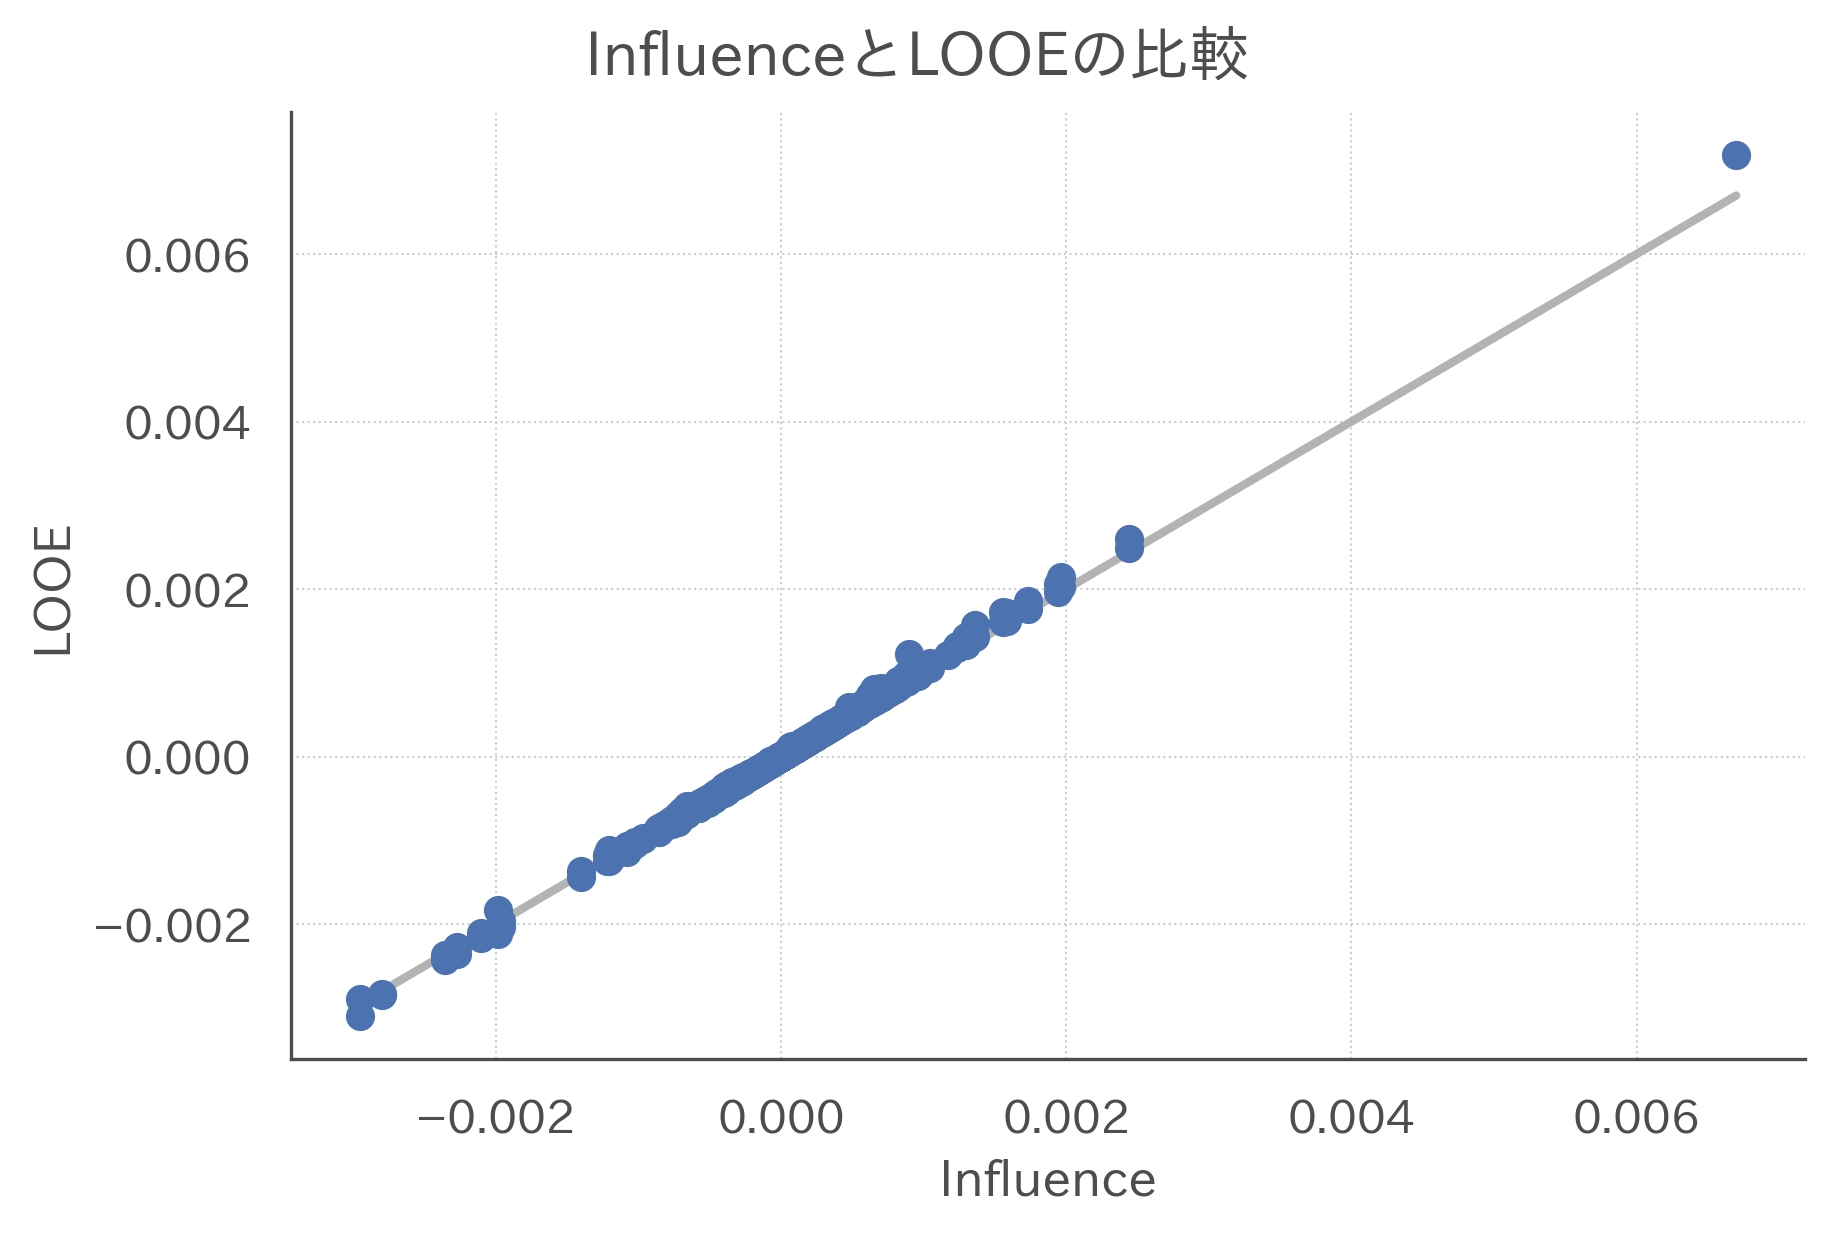

In [10]:
def draw_scatter_with_line(x: np.ndarray, y: np.ndarray, xlabel: str, ylabel: str, title: str):
    
    xx = np.linspace(x.min(), x.max(), num=50)
    
    fig, ax = plt.subplots()
    ax.plot(xx, xx, c='.7', linewidth=2, zorder=1)
    ax.scatter(x, y, zorder=2)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)
    fig.savefig(f"output/compare.png")
    fig.show()
    
draw_scatter_with_line(influence.flatten(), looe.flatten(), "Influence", "LOOE", "InfluenceとLOOEの比較")

## 参考文献

- Koh, Pang Wei, and Percy Liang. "Understanding black-box predictions via influence functions." International Conference on Machine Learning. PMLR, 2017.
- Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable." (2019). https://christophm.github.io/interpretable-ml-book/.
- Hansen, Bruce E. "Econometrics." (2021). https://www.ssc.wisc.edu/~bhansen/econometrics/.